In [1]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
%matplotlib inline

#https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

Using TensorFlow backend.


In [2]:
dataframe = read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
#Number of lines at bottom of file to skip

dataset = dataframe.values
dataset = dataset.astype('float32')
#floating point values more suitable for modeling with a neural network.

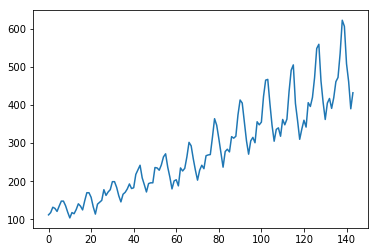

In [3]:
plt.plot(dataset)
plt.show()

In [4]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [5]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

96 48


#### look_back, which is the number of previous time steps to use as input variables to predict the next time period — in this case defaulted to 1.  
#### This default will create a dataset where X is the number of passengers at a given time (t) and Y is the number of passengers at the next time (t + 1).

In [6]:
dataset.shape

(144, 1)

In [7]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [9]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

The LSTM network expects the input data (X) to be provided with a specific array structure in the form of: [samples, time steps, features].

In [11]:
# reshape input to be [samples, time steps, features]
# timesteps 就是 LSTM 认为每个输入数据与前多少个陆续输入的数据有联系。
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM blocks. The network is trained for 100 epochs and a batch size of 1 is used.

In [13]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
1s - loss: 0.0337
Epoch 2/100
0s - loss: 0.0157
Epoch 3/100
0s - loss: 0.0123
Epoch 4/100
0s - loss: 0.0115
Epoch 5/100
0s - loss: 0.0107
Epoch 6/100
0s - loss: 0.0098
Epoch 7/100
0s - loss: 0.0089
Epoch 8/100
0s - loss: 0.0080
Epoch 9/100
0s - loss: 0.0071
Epoch 10/100
0s - loss: 0.0064
Epoch 11/100
0s - loss: 0.0056
Epoch 12/100
0s - loss: 0.0049
Epoch 13/100
0s - loss: 0.0042
Epoch 14/100
0s - loss: 0.0037
Epoch 15/100
0s - loss: 0.0032
Epoch 16/100
0s - loss: 0.0029
Epoch 17/100
0s - loss: 0.0026
Epoch 18/100
0s - loss: 0.0024
Epoch 19/100
0s - loss: 0.0023
Epoch 20/100
0s - loss: 0.0022
Epoch 21/100
0s - loss: 0.0021
Epoch 22/100
0s - loss: 0.0021
Epoch 23/100
0s - loss: 0.0021
Epoch 24/100
0s - loss: 0.0021
Epoch 25/100
0s - loss: 0.0020
Epoch 26/100
0s - loss: 0.0020
Epoch 27/100
0s - loss: 0.0020
Epoch 28/100
0s - loss: 0.0021
Epoch 29/100
0s - loss: 0.0020
Epoch 30/100
0s - loss: 0.0020
Epoch 31/100
0s - loss: 0.0021
Epoch 32/100
0s - loss: 0.0020
Epoch 33/100
0s -

In [14]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 23.05 RMSE
Test Score: 47.35 RMSE


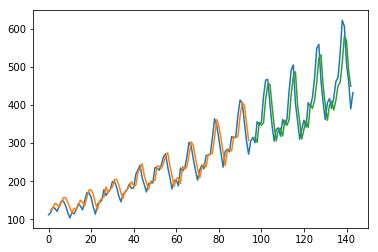

In [15]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

### multiple, recent time steps can be used to make the prediction for the next time step

In [8]:
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [10]:
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [14]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
1s - loss: 0.0592
Epoch 2/100
0s - loss: 0.0265
Epoch 3/100
0s - loss: 0.0171
Epoch 4/100
0s - loss: 0.0145
Epoch 5/100
0s - loss: 0.0129
Epoch 6/100
0s - loss: 0.0115
Epoch 7/100
0s - loss: 0.0103
Epoch 8/100
0s - loss: 0.0089
Epoch 9/100
0s - loss: 0.0078
Epoch 10/100
0s - loss: 0.0070
Epoch 11/100
0s - loss: 0.0063
Epoch 12/100
0s - loss: 0.0056
Epoch 13/100
0s - loss: 0.0053
Epoch 14/100
0s - loss: 0.0049
Epoch 15/100
0s - loss: 0.0047
Epoch 16/100
0s - loss: 0.0046
Epoch 17/100
0s - loss: 0.0044
Epoch 18/100
0s - loss: 0.0042
Epoch 19/100
0s - loss: 0.0043
Epoch 20/100
0s - loss: 0.0041
Epoch 21/100
0s - loss: 0.0040
Epoch 22/100
0s - loss: 0.0040
Epoch 23/100
0s - loss: 0.0041
Epoch 24/100
0s - loss: 0.0039
Epoch 25/100
0s - loss: 0.0040
Epoch 26/100
0s - loss: 0.0038
Epoch 27/100
0s - loss: 0.0037
Epoch 28/100
0s - loss: 0.0037
Epoch 29/100
0s - loss: 0.0038
Epoch 30/100
0s - loss: 0.0037
Epoch 31/100
0s - loss: 0.0036
Epoch 32/100
0s - loss: 0.0036
Epoch 33/100
0s -

In [15]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 25.80 RMSE
Test Score: 48.97 RMSE


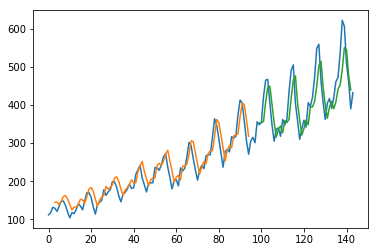

In [16]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## Stack LSTMs

One addition to the configuration that is required is that an LSTM layer prior to each subsequent LSTM layer must return the sequence. This can be done by setting the return_sequences parameter on the layer to True

Epoch 1/1
2s - loss: 0.0049
Epoch 1/1
0s - loss: 0.0101
Epoch 1/1
0s - loss: 0.0080
Epoch 1/1
0s - loss: 0.0067
Epoch 1/1
0s - loss: 0.0060
Epoch 1/1
0s - loss: 0.0056
Epoch 1/1
0s - loss: 0.0055
Epoch 1/1
0s - loss: 0.0054
Epoch 1/1
0s - loss: 0.0053
Epoch 1/1
0s - loss: 0.0053
Epoch 1/1
0s - loss: 0.0053
Epoch 1/1
0s - loss: 0.0052
Epoch 1/1
0s - loss: 0.0052
Epoch 1/1
0s - loss: 0.0052
Epoch 1/1
0s - loss: 0.0051
Epoch 1/1
0s - loss: 0.0051
Epoch 1/1
0s - loss: 0.0050
Epoch 1/1
0s - loss: 0.0050
Epoch 1/1
0s - loss: 0.0049
Epoch 1/1
0s - loss: 0.0048
Epoch 1/1
0s - loss: 0.0048
Epoch 1/1
0s - loss: 0.0047
Epoch 1/1
0s - loss: 0.0045
Epoch 1/1
0s - loss: 0.0044
Epoch 1/1
0s - loss: 0.0043
Epoch 1/1
0s - loss: 0.0041
Epoch 1/1
0s - loss: 0.0039
Epoch 1/1
0s - loss: 0.0037
Epoch 1/1
0s - loss: 0.0035
Epoch 1/1
0s - loss: 0.0034
Epoch 1/1
0s - loss: 0.0033
Epoch 1/1
0s - loss: 0.0033
Epoch 1/1
0s - loss: 0.0035
Epoch 1/1
0s - loss: 0.0036
Epoch 1/1
0s - loss: 0.0033
Epoch 1/1
0s - loss:

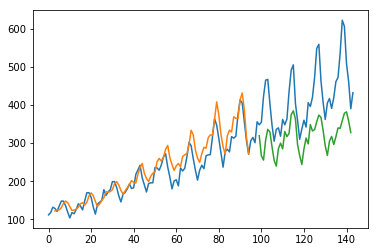

In [17]:
# Stacked LSTM for international airline passengers problem with memory

# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
# create and fit the LSTM network
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True,  return_sequences=True))
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(100):
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
    model.reset_states()
# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

### try using tensorflow directly later 

In [ ]:
n_steps = 1
n_inputs = 1
n_neurons = 4
n_outputs = 1
learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])      # stack the outputs to FC
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)    
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [ ]:
n_iterations = 100
batch_size = 1

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    
    saver.save(sess, "./my_time_series_model")